In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import keras
import sys

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from tensorflow.keras import layers

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

# Data Cleaning

In [34]:
# import data from CSV file
raw_data = pd.read_csv('NFLCombineData.csv')
print(raw_data.shape)

(4945, 25)


In [35]:
# quick test, to see how many values are missing for a specific parameter
parameter = 'fortyyd'
raw_data_no_outlier = raw_data.loc[raw_data[parameter] > 0]
print("Number of Players' Data Missing for -->", "\b", parameter, ":", raw_data.shape[0]-raw_data_no_outlier.shape[0])

Number of Players' Data Missing for -->  fortyyd : 191


In [70]:
# combining positions based on related characterisitcs into groupings (6 classes)
    # 0: Running Backs: RB, FB
    # 1: Pass Catchers: WR, TE
    # 2: Defensive Backs: FS, SS, CB
    # 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
    # 4: Linebackers: ILB, OLB
    # 5: Quarterback + Special Team: QB, P, K
    
# create dictionary of metrics corresponding to index in data
pos_dict = {'year': 0, 'name': 1, 'firstname': 2, 'lastname': 3, 'position': 4, 'heightfeet': 5, 
            'heightinches': 6, 'heightinchestotal': 7, 'weight': 8, 'arms': 9, 'hands': 10,
            'fortyyd': 11, 'twentyyd': 12, 'tenyd': 13, 'twentyss': 14, 'threecone': 15, 
            'vertical': 16, 'broad': 17, 'bench': 18, 'round': 19, 'college': 20, 
            'pickround': 21, 'picktotal': 22, 'wonderlic': 23, 'nflgrade': 24}

# extract all players (stored by position) from raw_data
rb = (raw_data.loc[raw_data['position'] == 'RB']).to_numpy()
fb = (raw_data.loc[raw_data['position'] == 'FB']).to_numpy()
wr = (raw_data.loc[raw_data['position'] == 'WR']).to_numpy()
te = (raw_data.loc[raw_data['position'] == 'TE']).to_numpy()
fs = (raw_data.loc[raw_data['position'] == 'FS']).to_numpy()
ss = (raw_data.loc[raw_data['position'] == 'SS']).to_numpy()
cb = (raw_data.loc[raw_data['position'] == 'CB']).to_numpy()
ot = (raw_data.loc[raw_data['position'] == 'OT']).to_numpy()
og = (raw_data.loc[raw_data['position'] == 'OG']).to_numpy()
oc = (raw_data.loc[raw_data['position'] == 'OC']).to_numpy()
c = (raw_data.loc[raw_data['position'] == 'C']).to_numpy()
nt = (raw_data.loc[raw_data['position'] == 'NT']).to_numpy()
dt = (raw_data.loc[raw_data['position'] == 'DT']).to_numpy()
de = (raw_data.loc[raw_data['position'] == 'DE']).to_numpy()
ls = (raw_data.loc[raw_data['position'] == 'LS']).to_numpy()
ilb = (raw_data.loc[raw_data['position'] == 'ILB']).to_numpy()
olb = (raw_data.loc[raw_data['position'] == 'OLB']).to_numpy()
qb = (raw_data.loc[raw_data['position'] == 'QB']).to_numpy()
p = (raw_data.loc[raw_data['position'] == 'P']).to_numpy()
k = (raw_data.loc[raw_data['position'] == 'K']).to_numpy()

# concatenate similar positions based on the classification of groups (detailed above)
run_back = np.concatenate((rb, fb))
pass_catch = np.concatenate((wr, te))
defense_back = np.concatenate((fs, ss, cb))
linemen = np.concatenate((ot, og, oc, c, nt, dt, de, ls))
lineback = np.concatenate((ilb, olb))
quarterback_special = np.concatenate((qb, p, k))

# Basic Preprocessing (no normalization or zero-meaning)

In [71]:
# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['weight', 'heightinchestotal', 'broad', 'fortyyd', 'bench']

#####################################################################################

# 0: Running Backs: RB, FB
for i in range(len(run_back)):
    rowArr = []
    for j in range(len(parameters)):
        rowArr.append(run_back[i][pos_dict.get(parameters[j])])
    data_players.append(np.array(rowArr))
    pos_index.append(0)
    
# 1: Pass Catchers: WR, TE
for i in range(len(pass_catch)):
    rowArr = []
    for j in range(len(parameters)):
        rowArr.append(pass_catch[i][pos_dict.get(parameters[j])])
    data_players.append(np.array(rowArr))
    pos_index.append(1)
    
# 2: Defensive Backs: FS, SS, CB
for i in range(len(defense_back)):
    rowArr = []
    for j in range(len(parameters)):
        rowArr.append(defense_back[i][pos_dict.get(parameters[j])])
    data_players.append(np.array(rowArr))
    pos_index.append(2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
for i in range(len(linemen)):
    rowArr = []
    for j in range(len(parameters)):
        rowArr.append(linemen[i][pos_dict.get(parameters[j])])
    data_players.append(np.array(rowArr))
    pos_index.append(3)
    
# 4: Linebackers: ILB, OLB
for i in range(len(lineback)):
    rowArr = []
    for j in range(len(parameters)):
        rowArr.append(lineback[i][pos_dict.get(parameters[j])])
    data_players.append(np.array(rowArr))
    pos_index.append(4)
    
# 5: Quarterback + Special Team: QB, P, K
for i in range(len(quarterback_special)):
    rowArr = []
    for j in range(len(parameters)):
        rowArr.append(quarterback_special[i][pos_dict.get(parameters[j])])
    data_players.append(np.array(rowArr))
    pos_index.append(5)
    
# convert from list to array
data_players = np.array(data_players)

# one-hot encode outputs for classifcation
pos_index = np.array(pos_index)
pos_cat = to_categorical(pos_index, 6)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled

# ALL GOOD SO FAR

Number of Players: 4945
Number of Metrics: 5
Number of Labels: 4945


In [109]:

model = keras.Sequential()
model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#model.add(Dense(6, activation="relu"))
#odel.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Simple data -> Softmax model

In [110]:
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 39us/step - loss: 136.6621 - accuracy: 0.1484 - val_loss: 132.9083 - val_accuracy: 0.0000e+00
Epoch 2/100
3956/3956 [==============================] - 0s 23us/step - loss: 91.0616 - accuracy: 0.1320 - val_loss: 97.1032 - val_accuracy: 0.0000e+00
Epoch 3/100
3956/3956 [==============================] - 0s 20us/step - loss: 49.6754 - accuracy: 0.1282 - val_loss: 59.3519 - val_accuracy: 0.0000e+00
Epoch 4/100
3956/3956 [==============================] - 0s 20us/step - loss: 14.6110 - accuracy: 0.1317 - val_loss: 48.0054 - val_accuracy: 0.0212
Epoch 5/100
3956/3956 [==============================] - 0s 20us/step - loss: 8.9110 - accuracy: 0.1593 - val_loss: 48.0793 - val_accuracy: 0.0354
Epoch 6/100
3956/3956 [==============================] - 0s 20us/step - loss: 7.9735 - accuracy: 0.2389 - val_loss: 48.3097 - val_accuracy: 0.0415
Epoch 7/100
3956/3956 [==============================

Epoch 56/100
3956/3956 [==============================] - 0s 20us/step - loss: 0.6802 - accuracy: 0.6823 - val_loss: 56.6900 - val_accuracy: 0.0718
Epoch 57/100
3956/3956 [==============================] - 0s 19us/step - loss: 0.6708 - accuracy: 0.7035 - val_loss: 56.8805 - val_accuracy: 0.0688
Epoch 58/100
3956/3956 [==============================] - 0s 20us/step - loss: 0.6671 - accuracy: 0.6959 - val_loss: 56.9129 - val_accuracy: 0.0556
Epoch 59/100
3956/3956 [==============================] - 0s 21us/step - loss: 0.6708 - accuracy: 0.6901 - val_loss: 56.9122 - val_accuracy: 0.0617
Epoch 60/100
3956/3956 [==============================] - 0s 20us/step - loss: 0.6676 - accuracy: 0.6929 - val_loss: 56.9516 - val_accuracy: 0.0576
Epoch 61/100
3956/3956 [==============================] - 0s 21us/step - loss: 0.6745 - accuracy: 0.6974 - val_loss: 57.1056 - val_accuracy: 0.0526
Epoch 62/100
3956/3956 [==============================] - 0s 21us/step - loss: 0.6706 - accuracy: 0.6982 - val_l

Text(0.5, 1.0, 'accuracy')

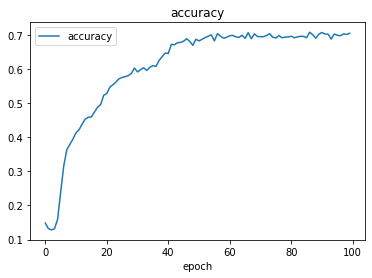

In [111]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

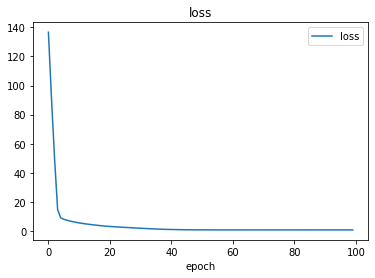

In [112]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

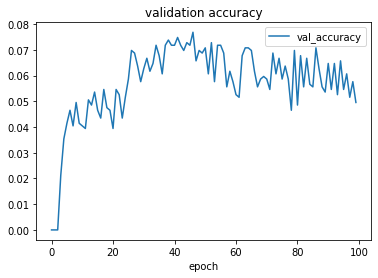

In [113]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [114]:
#Very low to begin with and decreases over time

Text(0.5, 1.0, 'validation loss')

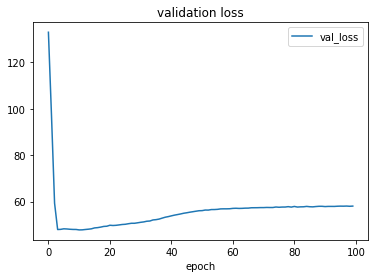

In [115]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

In [116]:
#increases over time oops

In [117]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [2 2 1 1 1 0 1 0 2 1 0 0 0 2 1 1 2 1 0 2 1 2 1 1 2 2 0 0 2 1 2 0 0 0 2 2 0
 1 2 1 0 2 1 1 1 1 0 0 2 2 1 2 1 2 2 2 2 2 1 0 2 0 2 1 1 1 0 1 2 0 2 0 0 2
 0 1 2 2 2 2 2 0 2 0 2 1 1 1 0 2 2 0 2 0 1 1 2 0 0 1 2 0 0 2 2 2 0 0 0 1 2
 1 2 2 2 2 0 0 1 0 1 2 1 2 2 1 1 2 0 0 2 1 0 2 0 2 0 0 1 2 2 2 2 0 2 2 0 1
 2 0 2 0 2 2 2 2 0 1 2 2 2 2 1 2 2 1 0 1 2 0 2 1 1 1 0 2 1 2 2 1 2 2 2 2 2
 2 1 2 2 2 2 2 2 1 2 1 0 2 0 0 0 2 2 2 2 2 2 2 2 2 2 2 1 0 0 2 1 2 2 1 2 2
 2 2 1 1 0 1 1 0 1 2 2 2 1 2 1 0 2 2 2 2 1 2 0 2 1 2 0 3 1 2 2 2 0 1 2 1 1
 1 2 1 1 1 2 2 2 2 0 2 1 2 2 1 1 2 2 2 2 1 0 2 1 0 0 1 2 0 1 0 2 2 2 2 1 0
 2 2 3 0 0 1 2 2 2 1 2 2 1 2 2 1 1 2 1 0 1 1 2 1 1 1 2 0 2 0 2 1 1 0 2 0 1
 2 1 0 2 0 1 2 2 1 1 1 2 2 1 2 2 0 0 2 0 2 2 2 2 2 2 2 1 2 2 1 1 1 1 2 1 1
 2 2 2 2 2 2 1 2 2 1 1 2 1 2 1 0 1 1 0 0 1 1 2 1 1 1 2 1 1 1 2 1 1 1 2 2 0
 2 0 2 2 2 0 1 1 0 2 2 1 0 2 2 1 2 1 2 2 0 1 2 2 2 1 2 1 2 2 2 0 1 1 1 2 1
 2 1 2 0 1 2 2 1 2 1 1 0 3 1 3 1 1 0 1 3 0 0 0 1 1 0 0 0 0 0 3 0 0 0 0 3 0
 0 1 0

In [118]:
#NEVER PREDICTS A 4 or 5!!!!!

# Simple Data -> ReLU + Softmax model

In [120]:
#TRYING DIFFERENT MODEL

In [122]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 47us/step - loss: 11.5561 - accuracy: 0.4583 - val_loss: 74.2734 - val_accuracy: 0.0768
Epoch 2/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.0567 - accuracy: 0.6175 - val_loss: 72.3058 - val_accuracy: 0.0506
Epoch 3/100
3956/3956 [==============================] - 0s 23us/step - loss: 0.9255 - accuracy: 0.6411 - val_loss: 71.5243 - val_accuracy: 0.0000e+00
Epoch 4/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.8508 - accuracy: 0.6562 - val_loss: 69.1568 - val_accuracy: 0.0607
Epoch 5/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.8520 - accuracy: 0.6580 - val_loss: 67.2798 - val_accuracy: 0.0637
Epoch 6/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.9076 - accuracy: 0.6474 - val_loss: 65.5193 - val_accuracy: 0.0394
Epoch 7/100
3956/3956 [==============================] - 0s 22us/s

3956/3956 [==============================] - 0s 22us/step - loss: 0.6259 - accuracy: 0.7204 - val_loss: 40.9884 - val_accuracy: 0.0677
Epoch 57/100
3956/3956 [==============================] - 0s 23us/step - loss: 0.6293 - accuracy: 0.7257 - val_loss: 43.6676 - val_accuracy: 0.0637
Epoch 58/100
3956/3956 [==============================] - 0s 23us/step - loss: 0.6202 - accuracy: 0.7318 - val_loss: 40.9205 - val_accuracy: 0.0688
Epoch 59/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.6404 - accuracy: 0.7235 - val_loss: 36.1784 - val_accuracy: 0.0647
Epoch 60/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.6144 - accuracy: 0.7305 - val_loss: 39.9888 - val_accuracy: 0.0485
Epoch 61/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.6189 - accuracy: 0.7214 - val_loss: 42.8556 - val_accuracy: 0.0526
Epoch 62/100
3956/3956 [==============================] - 0s 21us/step - loss: 0.6310 - accuracy: 0.7214 - val_loss: 42.0936 

In [125]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

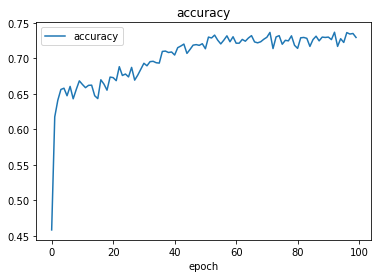

In [126]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

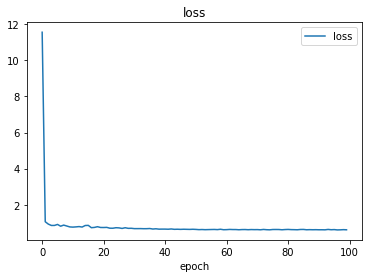

In [127]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

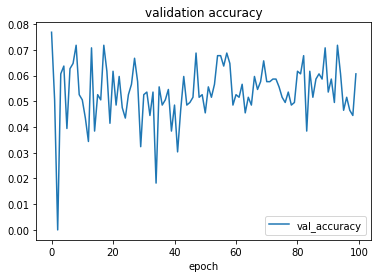

In [128]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [129]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

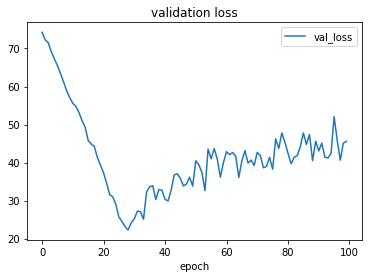

In [130]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

In [131]:
#increases over time oops

In [133]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [0 0 1 1 1 0 2 0 2 0 0 0 0 2 1 2 2 1 3 0 2 0 0 1 1 2 0 0 2 1 2 0 0 0 2 0 0
 2 0 2 0 0 1 1 1 1 0 0 2 2 1 0 1 0 0 0 2 2 0 0 2 0 0 1 1 0 0 0 2 0 0 3 0 0
 0 2 0 2 2 2 0 0 0 0 0 0 0 1 0 0 2 0 0 0 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 1 2
 1 1 0 2 2 0 0 1 0 2 0 1 0 2 1 0 0 0 0 2 2 0 0 0 0 3 0 1 2 2 0 0 0 0 2 0 2
 0 0 2 0 2 2 2 2 0 2 2 0 0 0 0 0 0 2 0 1 2 1 2 1 1 1 0 0 1 2 2 2 2 0 2 2 0
 2 1 2 2 0 2 2 0 2 2 0 0 2 0 0 0 0 0 2 2 0 0 0 0 0 2 2 1 0 0 2 2 2 0 2 0 2
 0 0 1 2 0 1 2 0 1 0 0 2 1 2 1 0 2 0 2 2 2 2 0 0 1 0 0 3 2 0 0 0 1 1 2 1 0
 2 2 1 1 1 0 0 2 0 0 0 2 0 2 2 0 0 2 0 2 0 0 2 2 0 0 0 2 3 1 0 2 0 0 2 1 0
 2 2 3 0 0 0 0 2 2 1 2 0 1 0 2 1 1 2 0 0 1 0 0 2 1 0 2 0 2 0 2 2 1 1 0 0 0
 0 0 0 2 0 0 2 2 1 0 0 2 2 2 0 0 0 0 2 3 1 0 2 2 0 2 0 1 2 2 1 0 1 1 2 0 0
 2 0 2 0 2 0 2 2 2 1 2 2 1 2 0 0 1 1 0 0 0 2 2 0 0 0 2 0 1 1 2 0 1 2 2 2 0
 2 0 2 0 0 0 1 1 0 2 0 1 0 2 2 2 2 0 2 0 1 1 2 0 2 2 0 1 2 2 2 0 1 0 1 2 0
 2 2 2 0 0 0 2 1 2 1 0 3 3 1 3 1 1 3 1 3 3 3 3 1 1 3 3 0 3 3 3 1 3 0 0 3 0
 0 1 0

# Zero-meaning and normalizing data for a select few combine events

In [170]:
#This time zero-meaning and normalizing player vectors

# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['weight', 'heightinchestotal', 'broad', 'fortyyd', 'bench']

#####################################################################################

def preprocess_data(position, index): #One of the concatenated numpy arrays defined above, such as "run_back" or "linemen"
    paramMeans = []
    #computing mean
    for j in range(len(parameters)):
        paramMean = 0
        count = 0
        for i in range(len(position)):
            stat = position[i][pos_dict.get(parameters[j])]
            paramMean += stat
            if (stat != 0):
                count += 1
        paramMeans.append(paramMean / count)
            
    #organizing data
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            #filling in zeroes
            if (stat != 0):
                #demeaning
                rowArr.append(stat - paramMeans[j])
            else:
                rowArr.append(paramMeans[j])
        #normalization
        rowArr = rowArr / np.linalg.norm(rowArr)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        

# 0: Running Backs: RB, FB
preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
preprocess_data(quarterback_special, 5)

# convert from list to array
data_players = np.array(data_players)

# one-hot encode outputs for classifcation
pos_index = np.array(pos_index)
pos_cat = to_categorical(pos_index, 6)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled
# ALL GOOD SO FAR

Number of Players: 4945
Number of Metrics: 5
Number of Labels: 4945


# Fancy data -> ReLu + Softmax model

In [206]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 47us/step - loss: 1.4002 - accuracy: 0.3994 - val_loss: 4.8183 - val_accuracy: 0.0758
Epoch 2/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.2865 - accuracy: 0.4358 - val_loss: 5.7431 - val_accuracy: 0.0586
Epoch 3/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.2735 - accuracy: 0.4553 - val_loss: 6.3617 - val_accuracy: 0.0647
Epoch 4/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.2634 - accuracy: 0.4555 - val_loss: 6.7209 - val_accuracy: 0.0657
Epoch 5/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.2627 - accuracy: 0.4568 - val_loss: 7.0571 - val_accuracy: 0.0637
Epoch 6/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.2571 - accuracy: 0.4548 - val_loss: 7.3143 - val_accuracy: 0.0627
Epoch 7/100
3956/3956 [==============================] - 0s 26us/step - loss:

3956/3956 [==============================] - 0s 22us/step - loss: 1.1840 - accuracy: 0.5018 - val_loss: 14.0621 - val_accuracy: 0.0566
Epoch 57/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.1823 - accuracy: 0.4997 - val_loss: 14.4204 - val_accuracy: 0.0617
Epoch 58/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.1860 - accuracy: 0.4972 - val_loss: 13.9654 - val_accuracy: 0.0597
Epoch 59/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.1836 - accuracy: 0.4997 - val_loss: 14.3821 - val_accuracy: 0.0647
Epoch 60/100
3956/3956 [==============================] - 0s 22us/step - loss: 1.1836 - accuracy: 0.4922 - val_loss: 14.5713 - val_accuracy: 0.0617
Epoch 61/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.1876 - accuracy: 0.5013 - val_loss: 14.2508 - val_accuracy: 0.0627
Epoch 62/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.1833 - accuracy: 0.4995 - val_loss: 14.1750 

In [207]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

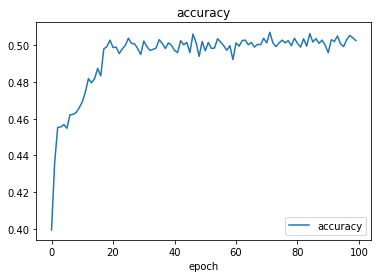

In [208]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

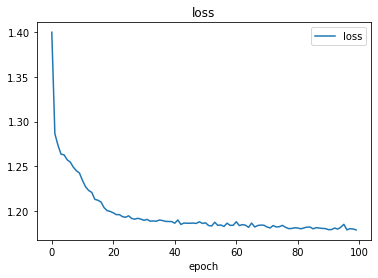

In [209]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

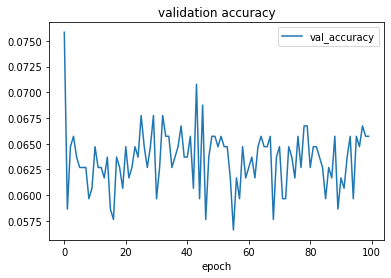

In [210]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [211]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

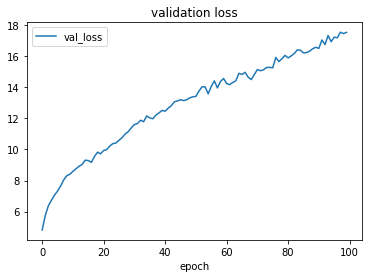

In [212]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

In [213]:
#increases over time oops

In [214]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [1 3 3 1 3 3 1 3 3 3 2 3 2 3 3 2 1 3 3 3 2 2 2 1 3 2 2 3 3 3 1 2 3 3 1 3 2
 2 2 1 3 2 3 2 3 3 3 3 3 1 3 3 3 1 2 3 3 3 3 3 3 2 1 2 3 3 3 2 1 2 1 3 3 2
 3 1 3 1 3 2 2 2 3 3 2 2 3 3 3 2 1 3 2 3 1 1 1 3 2 2 1 3 2 3 2 2 3 3 3 3 1
 3 3 1 3 1 2 2 3 1 1 3 1 1 1 3 3 1 3 3 3 3 2 3 3 1 3 3 1 2 3 3 2 3 2 3 3 2
 1 2 3 3 2 1 3 3 3 2 2 3 3 2 3 1 1 1 2 3 1 3 3 1 3 3 2 3 3 3 2 3 2 3 3 1 2
 2 1 3 2 3 2 3 1 3 3 3 3 2 3 1 3 1 2 3 2 1 2 2 3 1 3 3 2 3 3 3 2 2 1 1 3 2
 3 2 3 1 2 1 2 3 3 3 1 1 3 1 1 3 2 2 1 3 1 3 2 1 1 2 3 3 1 1 2 3 3 1 3 3 3
 1 3 3 3 3 3 2 1 2 2 3 1 2 1 1 3 2 2 2 3 3 3 2 2 3 2 3 2 3 2 1 3 1 2 2 3 3
 3 3 3 3 2 3 1 2 2 3 2 3 1 1 2 1 3 3 3 2 3 3 2 1 1 3 1 3 1 3 2 1 1 3 2 2 2
 3 3 3 1 3 3 3 3 3 3 3 2 2 2 2 2 3 2 3 3 1 3 3 2 2 2 2 2 1 3 3 2 2 3 3 3 2
 3 3 1 2 2 1 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 1 3 3 1 3 3 1 3
 3 3 3 1 3 3 1 1 2 1 2 1 3 2 3 2 1 3 3 1 3 3 3 1 1 2 2 3 3 3 1 3 3 3 3 2 3
 3 1 1 2 3 2 3 3 2 3 3 3 3 3 3 1 3 3 3 1 3 3 3 3 3 3 3 1 3 1 1 3 1 3 3 3 1
 3 3 1

In [ ]:
#Again no 4s or 5s

# Zero-meaning and normalizing data for all combine events

In [219]:
#Trying all parameters!

# initialize arrays to store data
data_players = []
pos_index = []

#####################################################################################

# *** MODIFY HERE, WHICH PARAMETERS TO EXTRACT AND TRAIN ON ***
parameters = ['year', 'heightfeet', 
            'heightinches', 'heightinchestotal', 'weight', 'arms', 'hands',
            'fortyyd', 'twentyyd', 'tenyd', 'twentyss', 'threecone', 
            'vertical', 'broad', 'bench', 'round', 
            'pickround', 'picktotal', 'wonderlic', 'nflgrade'] #all strings removed

#####################################################################################

def preprocess_data(position, index): #One of the concatenated numpy arrays defined above, such as "run_back" or "linemen"
    paramMeans = []
    #computing mean
    for j in range(len(parameters)):
        paramMean = 0
        count = 0
        for i in range(len(position)):
            stat = position[i][pos_dict.get(parameters[j])]
            paramMean += stat
            if (stat != 0):
                count += 1
        if (count == 0):   #sometimes there are no parameter stats for a certain position
            paramMeans.append(0)
        else:
            paramMeans.append(paramMean / count)
            
    #organizing data
    for i in range(len(position)):
        rowArr = []
        for j in range(len(parameters)):
            stat = position[i][pos_dict.get(parameters[j])]
            #filling in zeroes
            if (stat != 0):
                #demeaning
                rowArr.append(stat - paramMeans[j])
            else:
                rowArr.append(paramMeans[j])
        #normalization
        rowArr = rowArr / np.linalg.norm(rowArr)
        data_players.append(np.array(rowArr))
        pos_index.append(index)
        

# 0: Running Backs: RB, FB
preprocess_data(run_back, 0)
    
# 1: Pass Catchers: WR, TE
preprocess_data(pass_catch, 1)
    
# 2: Defensive Backs: FS, SS, CB
preprocess_data(defense_back, 2)
    
# 3: Lineman: OT, OG, OC, C, NT, DT, DE, LS 
preprocess_data(linemen, 3)
    
# 4: Linebackers: ILB, OLB
preprocess_data(lineback, 4)
    
# 5: Quarterback + Special Team: QB, P, K
preprocess_data(quarterback_special, 5)

# convert from list to array
data_players = np.array(data_players)

# one-hot encode outputs for classifcation
pos_index = np.array(pos_index)
pos_cat = to_categorical(pos_index, 6)

# if these output values don't match the commented values, then you probably broke something above
print("Number of Players:", len(data_players)) # --> should be 4945, meaning all players' data pulled
print("Number of Metrics:", len(data_players[0])) # --> should be (number of parameters), meaning all metrics pulled
print("Number of Labels:", len(pos_index)) # --> should be 4945, meaning all players' groupings labeled
# ALL GOOD SO FAR

Number of Players: 4945
Number of Metrics: 20
Number of Labels: 4945


In [220]:
model = keras.Sequential()
#model.add(Dense(units=6, input_shape=(len(parameters),), activation='softmax'))
model.add(Dense(6, activation="relu"))
model.add(Dense(6, activation="softmax"))
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
h = model.fit(x=data_players, y=pos_cat, validation_split = 0.2, verbose=1, epochs=100, shuffle=True)

Train on 3956 samples, validate on 989 samples
Epoch 1/100
3956/3956 [==============================] - 0s 48us/step - loss: 1.4438 - accuracy: 0.3627 - val_loss: 5.4078 - val_accuracy: 0.0768
Epoch 2/100
3956/3956 [==============================] - 0s 24us/step - loss: 1.3072 - accuracy: 0.4087 - val_loss: 6.7282 - val_accuracy: 0.0748
Epoch 3/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.2543 - accuracy: 0.4467 - val_loss: 7.2989 - val_accuracy: 0.0708
Epoch 4/100
3956/3956 [==============================] - 0s 25us/step - loss: 1.1887 - accuracy: 0.4939 - val_loss: 8.1548 - val_accuracy: 0.0627
Epoch 5/100
3956/3956 [==============================] - 0s 24us/step - loss: 1.1342 - accuracy: 0.5283 - val_loss: 8.6467 - val_accuracy: 0.0556
Epoch 6/100
3956/3956 [==============================] - 0s 23us/step - loss: 1.0911 - accuracy: 0.5483 - val_loss: 9.4549 - val_accuracy: 0.0586
Epoch 7/100
3956/3956 [==============================] - 0s 23us/step - loss:

3956/3956 [==============================] - 0s 23us/step - loss: 0.3761 - accuracy: 0.8822 - val_loss: 16.1362 - val_accuracy: 0.0748
Epoch 57/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.3727 - accuracy: 0.8885 - val_loss: 15.9031 - val_accuracy: 0.0758
Epoch 58/100
3956/3956 [==============================] - 0s 25us/step - loss: 0.3721 - accuracy: 0.8857 - val_loss: 16.4556 - val_accuracy: 0.0758
Epoch 59/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.3654 - accuracy: 0.8860 - val_loss: 16.3276 - val_accuracy: 0.0758
Epoch 60/100
3956/3956 [==============================] - 0s 22us/step - loss: 0.3643 - accuracy: 0.8862 - val_loss: 16.7195 - val_accuracy: 0.0748
Epoch 61/100
3956/3956 [==============================] - 0s 23us/step - loss: 0.3614 - accuracy: 0.8835 - val_loss: 16.9401 - val_accuracy: 0.0748
Epoch 62/100
3956/3956 [==============================] - 0s 24us/step - loss: 0.3598 - accuracy: 0.8921 - val_loss: 17.0569 

In [207]:
#Training yields very variable results each time????

Text(0.5, 1.0, 'accuracy')

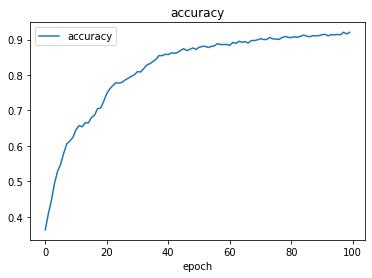

In [221]:
# display accuracy of model
plt.plot(h.history['accuracy'])
plt.xlabel('epoch')
plt.legend(['accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

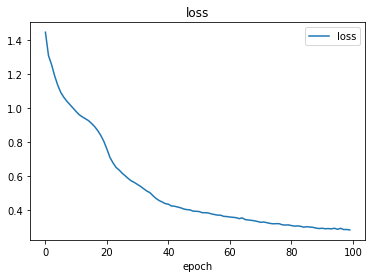

In [222]:
# display loss of model
plt.plot(h.history['loss'])
plt.xlabel('epoch')
plt.legend(['loss'])
plt.title('loss')

Text(0.5, 1.0, 'validation accuracy')

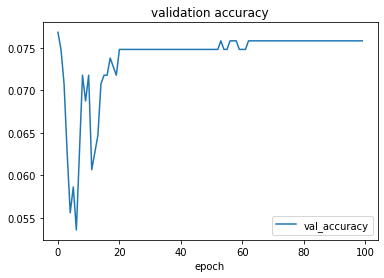

In [223]:
# display validation accuracy of model
plt.plot(h.history['val_accuracy'])
plt.xlabel('epoch')
plt.legend(['val_accuracy'])
plt.title('validation accuracy')

In [224]:
#Decreases over time

Text(0.5, 1.0, 'validation loss')

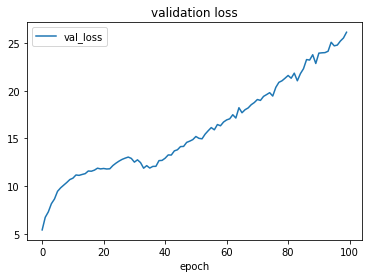

In [225]:
# display validation loss of model
plt.plot(h.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['val_loss'])
plt.title('validation loss')

In [226]:
#increases over time oops

In [227]:
# individually test for predictions on single point/group of points
point = np.array(data_players)
prediction = model.predict_classes(point)
print("Predicted Classes:", prediction)
print("Actual Classes:", pos_index)

Predicted Classes: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 2 0 0
 0 0 0 0 0 0 1 0 0 1 2 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 2 0 1 0 2 0 2 1 0 0
 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0 2 2 2 2 0 3 0 0 0 2 0 0 0
 2 2 1 0 0 0 0 2 0 2 0 2 2 0 2 0 0 0 2 2 2 2 0 0 0 0 0 1 2 0 1 1 2 0 0 0 2
 0 0 1 0 2 2 1 0 0 2 0 1 0 0 2 0 2 2 3 0 1 0 0 0 2 0 0 0 0 0 2 0 0 2 0 0 0
 1 0 1 2 0 0 2 0 0 0 0 1 0 0 0 2 0 2 0 2 1 0 0 0 0 0 0 0 0 2 2 0 0 2 2 2 0
 0 0 1 0 0 0 0 2 0 2 0 0 0 0 2 2 2 0 0 2 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0 0 2
 2 0 0 0 0 2 0 0 2 0 0 2 2 2 0 0 0 0 0 0 2 2 0 2 2 2 2 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 2 0 3 0 0 0 3 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 1 2 2 2 2 2 2
 0 0 2

In [ ]:
#Again no 4s or 5s